<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=173834062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install faiss-gpu pytorch-metric-learning
from fastai.vision.all import *

  Obtaining dependency information for faiss-gpu from https://files.pythonhosted.org/packages/a8/71/623896382d90a9a99adf3438aa2c575535ba37804be9701d66f3337afd83/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytorch-metric-learning from https://files.pythonhosted.org/packages/e4/e1/3ee45254ca21a3c2bdd3c60e8b0b79c74f177e87a1abeb300ac151f21492/pytorch_metric_learning-2.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 11.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1):
        x1 = self.get_embedding(x1)
        return x1
    def get_embedding(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x
backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(backbone.classifier[-1].in_features, 256, [1024, 512], 0.5, bn_final=True)
apply_init(head, nn.init.kaiming_normal_)

model=CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 85.2MB/s]


In [3]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers,regularizers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from collections import defaultdict
import random

def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, max(50, len(files))))
    return sampled_files

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files_sample, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
loaders = pets.dataloaders("/kaggle/input/the-oxfordiiit-pet-dataset/images")

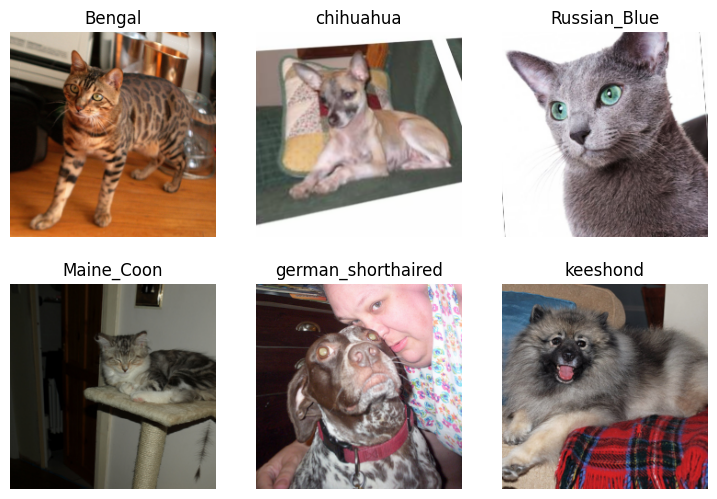

In [4]:
loaders.train.show_batch(max_n=6, nrows=2)

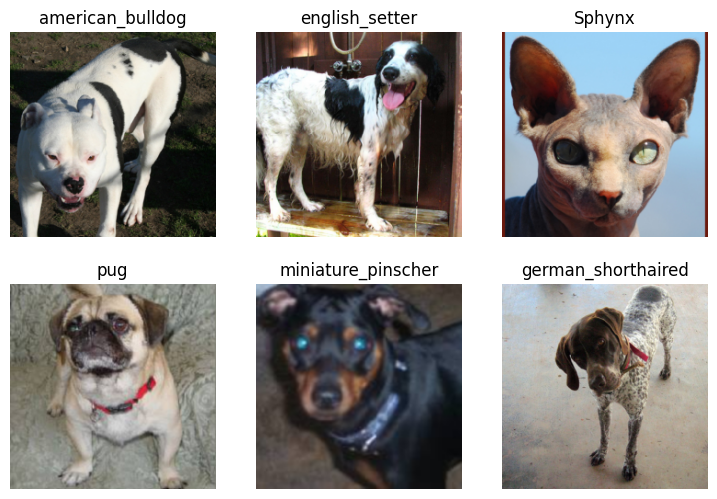

In [5]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [6]:
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0.2,high=1.8)
loss_func = losses.TripletMarginLoss(margin=1, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=1)

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
      mined = miner(embeddings, labels)
      return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func,
                     loss_func = loss_func)

In [7]:
learn=Learner(loaders, 
              model,
              loss_func=my_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback])

epoch,train_loss,valid_loss,time
0,0.775187,0.610216,01:22
1,0.642986,0.635328,01:18
2,0.605234,0.609407,01:17
3,0.588483,0.607891,01:17
4,0.563168,0.577793,01:18
5,0.550791,0.552674,01:18
6,0.539647,0.550881,01:18
7,0.535609,0.538877,01:17
8,0.527586,0.547077,01:17
9,0.513342,0.535338,01:17


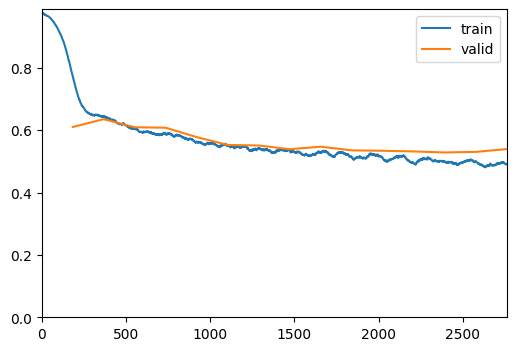

epoch,train_loss,valid_loss,time
0,0.481024,0.541676,01:43
1,0.487266,0.538081,01:43
2,0.477649,0.527531,01:43
3,0.477990,0.516213,01:43
4,0.474529,0.514069,01:43
5,0.459064,0.521309,01:43
6,0.464133,0.513082,01:43
7,0.455428,0.515240,01:43
8,0.447563,0.515754,01:43
9,0.441530,0.517788,01:43


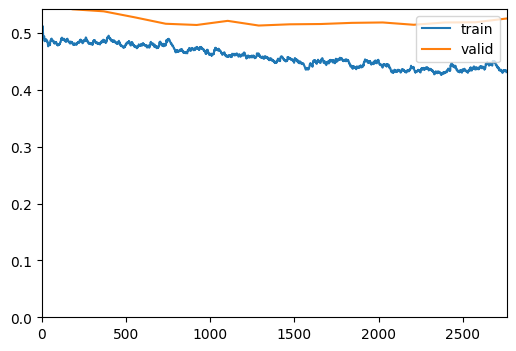

In [8]:
learn.fine_tune(15,freeze_epochs=15)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    embeddings, labels= tester.compute_all_embeddings(dataset,model,torch.nn.Identity())
    embeddings = tester.maybe_normalize(embeddings)
    return embeddings, labels

train_embeddings, train_labels = get_all_embeddings(loaders.valid, model)
test_embeddings, test_labels = get_all_embeddings(loaders.train, model)

# 将嵌入向量移动到CPU
train_embeddings = train_embeddings.cpu()
test_embeddings = test_embeddings.cpu()

train_labels = train_labels.squeeze(1).cpu().numpy()  # 将标签也移动到CPU，并转换为NumPy数组
test_labels = test_labels.squeeze(1).cpu().numpy()

# 使用KNN分类器
knn = KNeighborsClassifier()
knn.fit(train_embeddings, train_labels)

# 预测测试集的标签
test_pred = knn.predict(test_embeddings)

# 计算各种指标
accuracy = accuracy_score(test_labels, test_pred)
precision = precision_score(test_labels, test_pred, average='macro')
recall = recall_score(test_labels, test_pred, average='macro')
f1 = f1_score(test_labels, test_pred, average='macro')

print("Test set accuracy = {}".format(accuracy))
print("Test set precision = {}".format(precision))
print("Test set recall = {}".format(recall))
print("Test set F1 score = {}".format(f1))

100%|██████████| 184/184 [00:49<00:00,  3.72it/s]


Test set accuracy = 0.952638700947226
Test set precision = 0.9533596474259464
Test set recall = 0.9532519948883637
Test set F1 score = 0.952585234254568


In [10]:
hooks = Hooks(model.head, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))

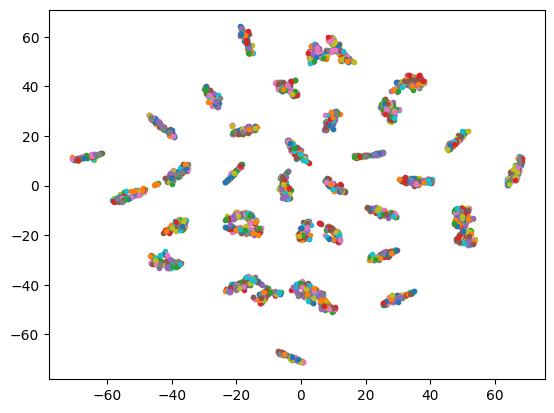

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

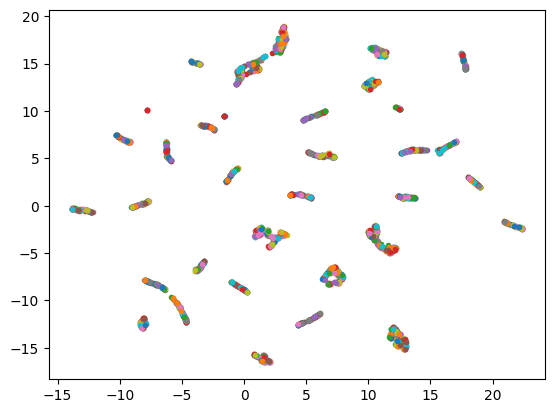

In [12]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')